<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="cognitiveclass.ai logo">
</center>


# Regularization Techniques


Estimated time needed: **60** minutes

The purpose of Regularization techniques is to reduce the degree of overfitting that can occur in Regression models. Overfitting leads to poor ability of the model to make predictions on the new, unseen data. As we saw in the previous Regression Lessons, with a creation of extra features, such as through polynomial regression, a model can become easily overfit. To reduce the overfitting, we can regularize the model, or in other words, we can decrease its degrees of freedom. A simple way to regularize polynomial model is to reduce the number of polynomial degrees. For a linear regression model, regularization is typically achieved by constraining the weights of the model. Regularizer imposes a penalty on the size of the coefficients of the model.

In this lab, we will cover three types of regularizers:

*   Ridge regression
*   Lasso regression
*   Elastic Net

Each one has its own advantages and disadvantages. Lasso will eliminate many features and reduce overfitting in your linear model. Ridge will reduce the impact of the features that are not important in predicting your target. Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

The common features of all these regularizers include using cross-validation to select hyperparameters and applying data normalization to improve the performance.

## Objectives

After completing this lab you will be able to:

*   Understand the advantages and disadvantages of Ridge, Lasso and Elastic Net Regressions
*   Apply Ridge, Lasso and Elastic Net Regressions
*   Perform  hyperparameters Grid Search on a model using validation data


***


## **Setup**


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) for mathematical operations.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) for visualizing the data.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`scipy`](https://docs.scipy.org/doc/scipy/tutorial/stats.html/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) for statistical computations.


## **Import the required libraries**


In [ ]:
# Install the required libraries
!pip install -U scikit-learn
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib

In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np 

import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA



First, let's define some functions that will help us in the future analysis.

Below function will calculate the $R^{2}$ on each feature given the input of the model.


In [3]:
def get_R2_features(model,test=True): 
    #X: global  
    features=list(X)
    features.remove("three")
    
    R_2_train=[]
    R_2_test=[]

    for feature in features:
        model.fit(X_train[[feature]],y_train)
        
        R_2_test.append(model.score(X_test[[feature]],y_test))
        R_2_train.append(model.score(X_train[[feature]],y_train))
        
    plt.bar(features,R_2_train,label="Train")
    plt.bar(features,R_2_test,label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()
    print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
    print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )

Below function will plot the estimated coefficients for each feature and find $R^{2}$ on training and testing sets.


In [4]:
def plot_coef(X,model,name=None):
    

    plt.bar(X.columns[2:],abs(model.coef_[2:]))
    plt.xticks(rotation=90)
    plt.ylabel("$coefficients$")
    plt.title(name)
    plt.show()
    print("R^2 on training  data ",model.score(X_train, y_train))
    print("R^2 on testing data ",model.score(X_test,y_test))
    

Below function plots the distribution of two inputs.


In [5]:
def  plot_dis(y,yhat):
    
    plt.figure()
    ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

## **Reading and understanding our data**


For this lab, we will be using the car sales dataset, hosted on IBM Cloud object storage. The dataset contains all the information about cars, the name of the manufacturer, the year it was launched, all car technical parameters, and the sale price. This dataset has already been pre-cleaned and encoded (using one-hot and label encoders) in the Linear Regression Notebook.


Let's read the data into *pandas* data frame and look at the first 5 rows using the `head()` method.


In [6]:
data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/encoded_car_data.csv')
data.head()

,diesel,gas,std,turbo,convertible,hardtop,hatchback,sedan,wagon,4wd,...,wheelbase,curbweight,enginesize,boreratio,horsepower,carlength,carwidth,citympg,highwaympg,price
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,13495.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,16500.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,94.5,2823.0,152.0,2.68,154.0,171.2,65.5,19.0,26.0,16500.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,99.8,2337.0,109.0,3.19,102.0,176.6,66.2,24.0,30.0,13950.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,99.4,2824.0,136.0,3.19,115.0,176.6,66.4,18.0,22.0,17450.0


We can find more information about the features and types using the `info()`  method.


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diesel       205 non-null    float64
 1   gas          205 non-null    float64
 2   std          205 non-null    float64
 3   turbo        205 non-null    float64
 4   convertible  205 non-null    float64
 5   hardtop      205 non-null    float64
 6   hatchback    205 non-null    float64
 7   sedan        205 non-null    float64
 8   wagon        205 non-null    float64
 9   4wd          205 non-null    float64
 10  fwd          205 non-null    float64
 11  rwd          205 non-null    float64
 12  dohc         205 non-null    float64
 13  dohcv        205 non-null    float64
 14  l            205 non-null    float64
 15  ohc          205 non-null    float64
 16  ohcf         205 non-null    float64
 17  ohcv         205 non-null    float64
 18  rotor        205 non-null    float64
 19  eight   

## Data Preparation

Let's first split our data into `X` features and `y` target.


In [8]:
X = data.drop('price', axis=1)
y = data.price

Now that we have split our data into training and testing sets, the training data is used for your model to recognize patterns using some criteria,the test data set it used to evaluate your model, as shown in the following image:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/images/trin-test.png">
</center>
<center>source scikit-learn.org</center>


Now, we split our data, using <code>train_test_split</code> function, into the training and testing sets, allocating 30% of the data for testing.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print("number of test samples :", X_test.shape[0])
print("number of training samples:",X_train.shape[0])


number of test samples : 62
number of training samples: 143


## Linear Regression

In linear  regression we are trying to find the value of $\textbf{w}$ that  minimizes the Mean Squared Error (MSE), we can represent this using the following expression:


$\hat{\textbf{w}}= \underset{\textbf{w}}{\mathrm{argmin}} {
||\textbf{y}  - \textbf{Xw} ||^2_2}$


Where $\textbf{y}$ is the target, $\textbf{X}$ is the training set and $\textbf{w}$ is the parameter weights. The resulting $\hat{\textbf{w}}$ is the best value to minimize the MSE, i.e., the distance between the target $\textbf{y}$ and the estimate $\textbf{Xw}$. We do this by fitting the model.


Let's create a <code>LinearRegression</code> object, called `lm`.


In [11]:
lm = LinearRegression()

Now, let's fit the model with multiple features on our X_train and y_train data.


In [12]:
lm.fit(X_train, y_train)

LinearRegression()

We apply `predict(`) function on the testing data set.


In [13]:
predicted = lm.predict(X_test)

Let's calculate the `$R^2$` on both, training and testing data sets.


In [14]:
print("R^2 on training  data ",lm.score(X_train, y_train))
print("R^2 on testing data ",lm.score(X_test,y_test))

R^2 on training  data  0.9262722224294516
R^2 on testing data  0.8471124710252232


We can plot a distribution of the predicted values vs the actual values.


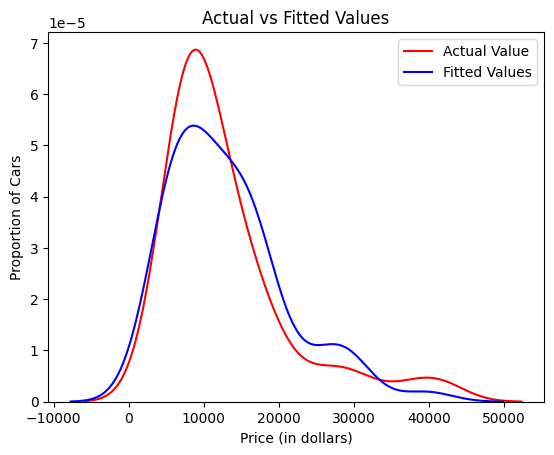

In [15]:
plot_dis(y_test,predicted)

We can view the estimated coefficients for the linear regression problem and drop the top two coefficients, as they are two large.


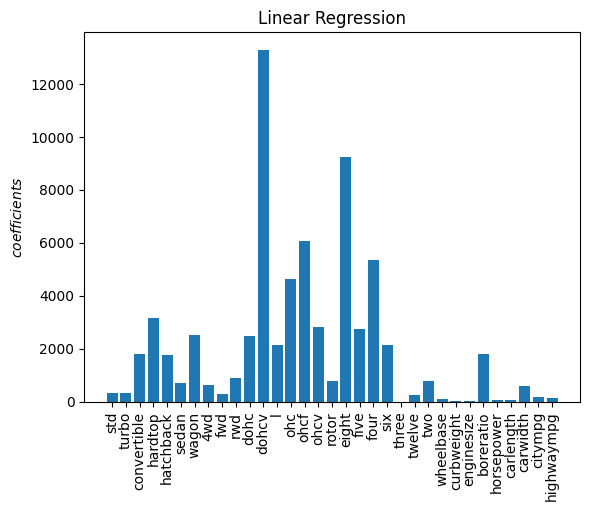

R^2 on training  data  0.9262722224294516
R^2 on testing data  0.8471124710252232


In [16]:
plot_coef(X,lm,name="Linear Regression")

## Ridge Regression


Let's review the Ridge Regression. Ridge Regression makes the prior assumption that our coefficients are normally distributed around zero. A regularization term, alpha, is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. The variance of the distribution is inversely proportional to the parameter alpha. This is also called the  L2 regularizer , as it adds a L2 penalty to the minimization term, as shown here:

$\hat{\textbf{w}}= \underset{\textbf{w}}{\mathrm{argmin}} {
||\textbf{y}  - \textbf{Xw} ||^2_2+ \alpha  ||\textbf{w}||_2 }$

We minimize the MSE, but we also penalize large weights by including their magnitude $||\textbf{w}||\_2$ in the minimization term. This additional minimization term makes the model less susceptible to noise and makes the weights smaller. Alpha controls the takeoff between MSE and penalization or regularization term and is chosen via cross-validation.


Let's see  how the parameter alpha changes the model. Note, here our test data will be used as validation data. Also, the regularization term should only be added to the cost function during the training.

Let's create a Ridge Regression object, setting the regularization parameter (alpha) to 0.01.


In [17]:
rr = Ridge(alpha=0.01)
rr

Ridge(alpha=0.01)

Like regular regression, you can fit the model using the `fit()` method.


In [18]:
rr.fit(X_train, y_train)

Ridge(alpha=0.01)

Similarly, you can obtain a prediction:


In [19]:
rr.predict(X_test)

array([27598.326873  , 21371.22387854, 10760.95940989, 12111.7976642 ,
       26104.61526939,  5420.80558182,  8038.73622302,  7558.7584293 ,
       10088.50457197,  9434.40202964, 17328.20366356,  7276.77101381,
       16442.40304417, 10820.55785225, 39642.68328022,  5532.64570913,
        2223.48274138, 15704.2551402 , 10795.80882429, 11445.69022623,
       10869.49226403, 15847.09411047, 10601.08457888,  3598.67058534,
        7007.60644617, 28598.41184812, 18455.46252113, 15173.62941095,
        4452.47193894, 16400.79617624, 26787.78275612,  5805.73648313,
        4904.13554999, 16743.20407026,  8386.05980122, 30491.9258854 ,
       12381.70808121, 12997.76584967,  6284.21248199, 16133.48808554,
        8154.05990242, 15088.646679  , 14726.67293205,  5249.70079409,
        6261.47439111,  9115.33978834,  5805.73648313,  7240.34422195,
       16679.32730582, 15561.37722608,  5019.75853115, 21822.09787812,
        7068.35655245, 11454.04169241,  4389.88795114, 16500.07849587,
      

We can calculate the $R^2$ on the training and testing data.


In [20]:
print("R^2 on training  data ",rr.score(X_train, y_train))
print("R^2 on testing data ",rr.score(X_test,y_test))

R^2 on training  data  0.9262583145923291
R^2 on testing data  0.8454081419624927


Now let's compare the Ridge Regression and the Linear Regression  models. The results on the $R^2$ are about the same, and the coefficients seem to be smaller.


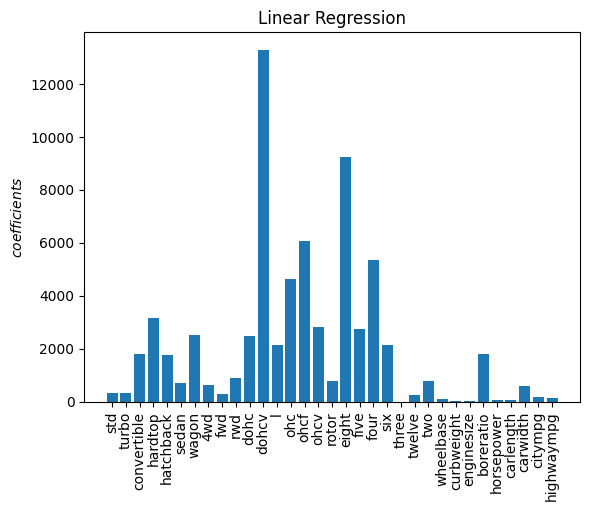

R^2 on training  data  0.9262722224294516
R^2 on testing data  0.8471124710252232


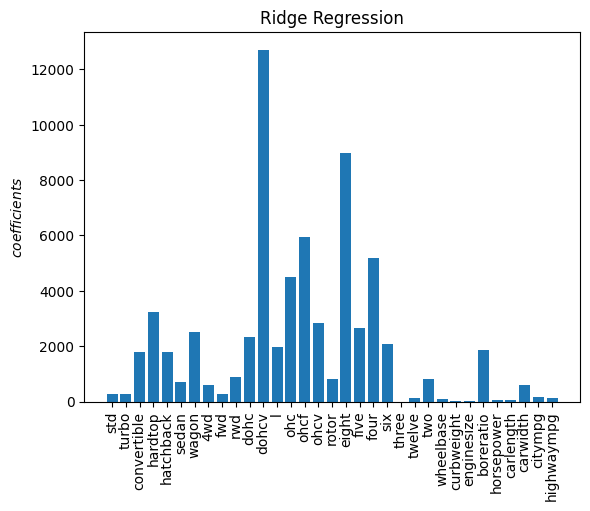

R^2 on training  data  0.9262583145923291
R^2 on testing data  0.8454081419624927


In [21]:
plot_coef(X,lm,name="Linear Regression")
plot_coef(X,rr,name="Ridge Regression")

If we increase alpha, the coefficients get smaller, but the results are not as good as our previous value of alpha.


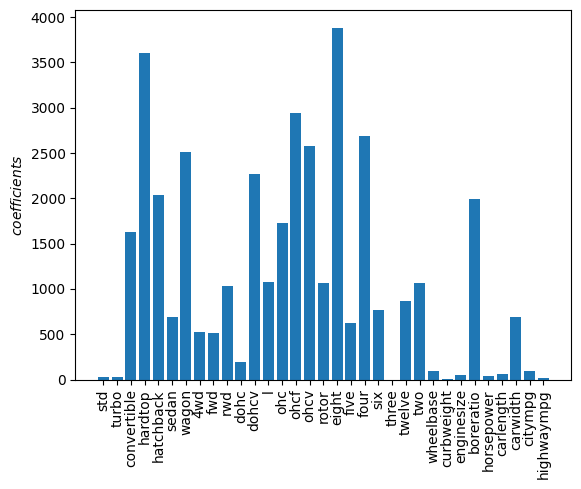

R^2 on training  data  0.9190312321691605
R^2 on testing data  0.807983068907448


In [22]:
rr = Ridge(alpha=1)
rr.fit(X_train, y_train)
plot_coef(X,rr)

In general, we see that if we increase alpha, the coefficients get smaller, but the model performance relationship gets more complex. As a result, we use the validation data to select a value for alpha. Here, we plot the coefficients and $R^2$ of the test data on the vertical axes and alpha on the horizontal axis, as well the $R^2$ using the test data.


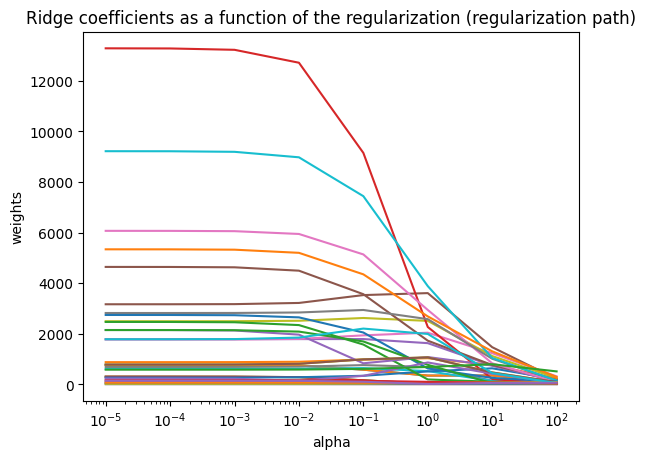

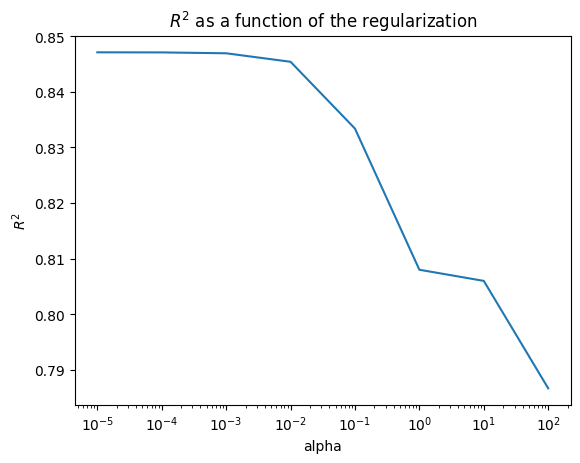

In [23]:
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
R_2=[]
coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefs.append(abs(ridge.coef_))
    R_2.append(ridge.score(X_test,y_test))


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization (regularization path)")
plt.show()


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()          

As we increase alpha, the coefficients get smaller but the $R^2$ peaks when alpha is 1.


## Exercise 1

In this Exercise, plot the MSE as a function of alpha. What pattern do you notice?


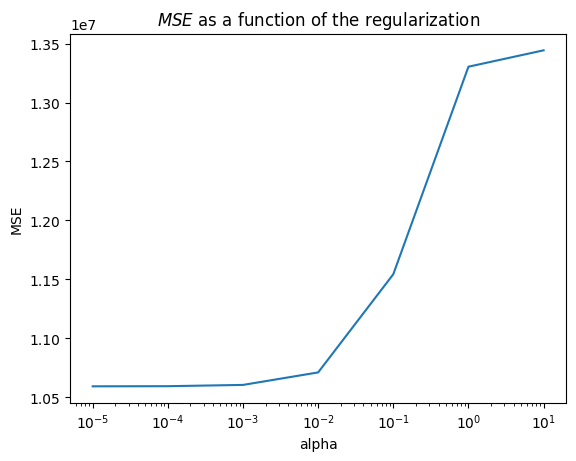

In [24]:
# Enter your code and run the cell
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10]
MEAN_SQE=[]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    MEAN_SQE.append(mean_squared_error(ridge.predict(X_test),y_test))

ax = plt.gca()
ax.plot(alphas, MEAN_SQE)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("$MSE$ as a function of the regularization")
plt.show()

<details>
    <summary>Click here for Solution</summary>

```python
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10]
MEAN_SQE=[]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    MEAN_SQE.append(mean_squared_error(ridge.predict(X_test),y_test))

ax = plt.gca()
ax.plot(alphas, MEAN_SQE)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("$MSE$ as a function of the regularization")
plt.show()
```

</details>


<details>
    <summary><strong>Answers</strong> (Click Here)</summary>
A small alpha leads to over-fitting but as alpha gets larger the MSE decreases. When alpha gets too large the MSE increases leading to underfitting. The optimal point seems to be in the middle .
</details>


## Pipeline


We can also create a Pipeline object and apply a set of transforms sequentially. Then, we can apply Polynomial Features, perform data standardization then apply Ridge regression.  Data Pipelines simplify the steps of processing the data. We use the module `Pipeline` to create a pipeline. We also use `StandardScaler` step in our pipeline. Scaling our data is necessary step in Ridge regression as it will penalize features with a large magnitude.

Now, we create a pipeline object.


In [25]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
pipe = Pipeline(Input)

We fit the object.


In [26]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()), ('model', Ridge(alpha=1))])

We can calculate the score on the test data.


In [27]:
predicted=pipe.predict(X_test)
pipe.score(X_test, y_test)

0.8789668271159616

Looking for hyperparameters can get difficult with loops. The problem will get worse as we add more transforms such as polynomial transform. Therefore, we can use `GridSearchCV` to make things simpler.


## GridSearchCV


To search for the best combination of hyperparameters we can create a  `GridSearchCV()` function as a dictionary of parameter values. The parameters of pipelines can be set by using the name of the key, separated by "\__", then the parameter. Here, we look for different polynomial degrees and different values of alpha.


In [28]:
param_grid = {
    "polynomial__degree": [1,2,3,4],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10]
}

Keys of the dictionary are the model "key name \__" followed by the parameter as an attribute.


<b>polynomial\_\_degree</b>: is the degree of the polynomial; in this case 1, 2, 3, 4 and 5.

<b>model\_\_alpha </b>: Regularization strength; must be a positive float.


We create a `GridSearchCV` object and fit it. The method trains the model and the hyperparameters are selected via exhaustive search over the specified values.


In [29]:
search = GridSearchCV(pipe, param_grid, n_jobs=2)

search.fit(X_train, y_train)
search

GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', Ridge(alpha=1))]),
             n_jobs=2,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'polynomial__degree': [1, 2, 3, 4]})

We can input the results into *pandas* `DataFrame()` as a dictionary with keys as column headers and values as columns and display the results.


In [30]:
pd.DataFrame(search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_polynomial__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002024,0.002319,0.000770,0.000945,0.0001,1,"{'model__alpha': 0.0001, 'polynomial__degree': 1}",0.732398,0.667762,0.942160,0.871065,0.682438,0.779165,0.108597,9
1,0.004237,0.000626,0.002171,0.001162,0.0001,2,"{'model__alpha': 0.0001, 'polynomial__degree': 2}",-0.965176,-0.003728,-0.094067,-4.630618,-1.002718,-1.339261,1.698257,22
2,0.056666,0.003246,0.006897,0.002498,0.0001,3,"{'model__alpha': 0.0001, 'polynomial__degree': 3}",-0.846010,-3.023706,-2.861025,-1.443010,-1.464688,-1.927688,0.859265,23
3,0.734593,0.095637,0.080271,0.010345,0.0001,4,"{'model__alpha': 0.0001, 'polynomial__degree': 4}",-2.180161,-4.494954,-4.848157,-1.889425,-3.595880,-3.401715,1.191997,24
4,0.005037,0.002681,0.000782,0.000760,0.0010,1,"{'model__alpha': 0.001, 'polynomial__degree': 1}",0.732422,0.667772,0.942164,0.871078,0.682524,0.779192,0.108581,8


There are some other useful attributes:


`best_score_`: mean cross-validated score of the `best_estimator`.

`best_params_dict`: parameter setting that gives the best results on the hold-out data.


In [31]:
print("best_score_: ",search.best_score_)
print("best_params_: ",search.best_params_)

best_score_:  0.8720367357066007
best_params_:  {'model__alpha': 10, 'polynomial__degree': 2}


We can call `predict()` on the estimator with the best found parameters.


In [32]:

predict = search.predict(X_test)

predict 

array([30903.03765092, 23959.40886577,  9479.23784499, 13565.35356241,
       28579.65716496,  6304.25672926,  6583.34397234,  8045.9676453 ,
        8609.49490676,  9258.30927411, 14161.92398937,  7064.656928  ,
       17369.17195974, 10622.50446159, 40442.34852823,  6435.25658865,
       -1671.0246256 , 13555.86035342,  9933.24405079,  9358.46879068,
       10379.83122929, 14845.47794683,  3652.64571964,  3189.13904682,
        7155.53959618, 32300.3759433 , 10726.99924888, 16540.06247528,
        5577.15710176, 17304.09531097, 28667.21031119,  6554.235394  ,
        5547.7872642 , 21836.54871944,  7693.04693925, 27252.89916535,
       13978.46840018, 13539.55291633,  6272.57325554, 13999.91030984,
        6816.48699277, 13115.60478653, 14532.40969315,  6568.72392904,
        6613.35511383,  9128.61080739,  6554.235394  ,  6335.52712991,
       15645.84472447, 13459.30924852,  5345.7044892 , 15701.34738144,
        6241.40892908, 10141.17008461,  5527.17931522, 13078.28077423,
      

We can find the best model.


In [33]:
best=search.best_estimator_
best

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()), ('model', Ridge(alpha=10))])

As we can see from the above output, it is five degree polynomial with alpha value of 0.0001.
Now, let's make a prediction.


In [34]:
predict = best.predict(X_test)
predict

array([30903.03765092, 23959.40886577,  9479.23784499, 13565.35356241,
       28579.65716496,  6304.25672926,  6583.34397234,  8045.9676453 ,
        8609.49490676,  9258.30927411, 14161.92398937,  7064.656928  ,
       17369.17195974, 10622.50446159, 40442.34852823,  6435.25658865,
       -1671.0246256 , 13555.86035342,  9933.24405079,  9358.46879068,
       10379.83122929, 14845.47794683,  3652.64571964,  3189.13904682,
        7155.53959618, 32300.3759433 , 10726.99924888, 16540.06247528,
        5577.15710176, 17304.09531097, 28667.21031119,  6554.235394  ,
        5547.7872642 , 21836.54871944,  7693.04693925, 27252.89916535,
       13978.46840018, 13539.55291633,  6272.57325554, 13999.91030984,
        6816.48699277, 13115.60478653, 14532.40969315,  6568.72392904,
        6613.35511383,  9128.61080739,  6554.235394  ,  6335.52712991,
       15645.84472447, 13459.30924852,  5345.7044892 , 15701.34738144,
        6241.40892908, 10141.17008461,  5527.17931522, 13078.28077423,
      

We can calculate the $R^2$ on the test data.


In [35]:
best.score(X_test, y_test)

0.9052548681611056

As we see, using Ridge Regression polynomial function works better than all other models. Finely, we can train our model on the entire data set!


In [36]:
best.fit(X,y)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()), ('model', Ridge(alpha=10))])

## Exercise 2

Perform grid search on the following features and plot the results by completing the following lines of code:


In [37]:
# Run the cell
columns=['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'horsepower',
       'carlength', 'carwidth', 'citympg']


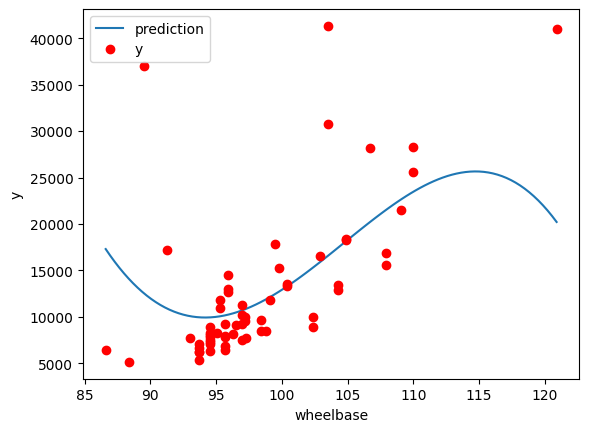

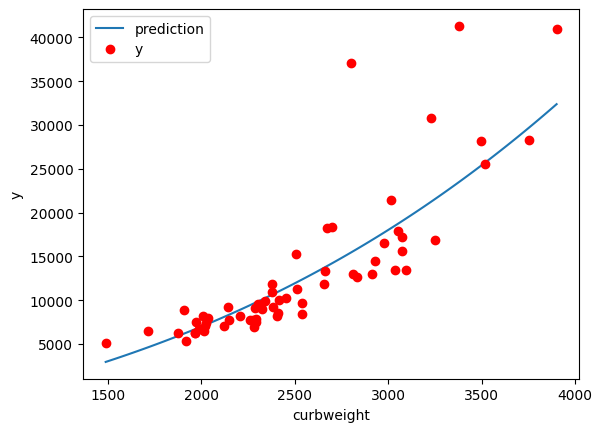

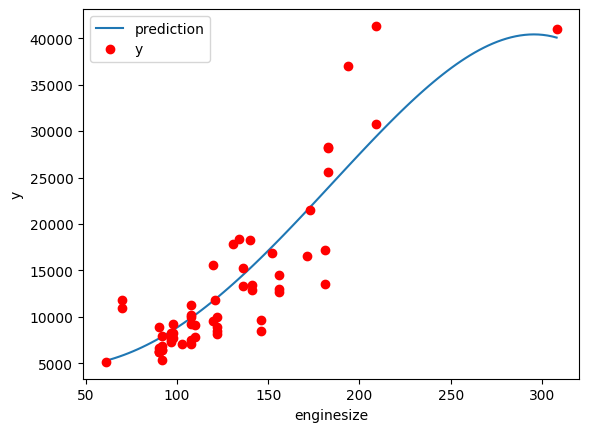

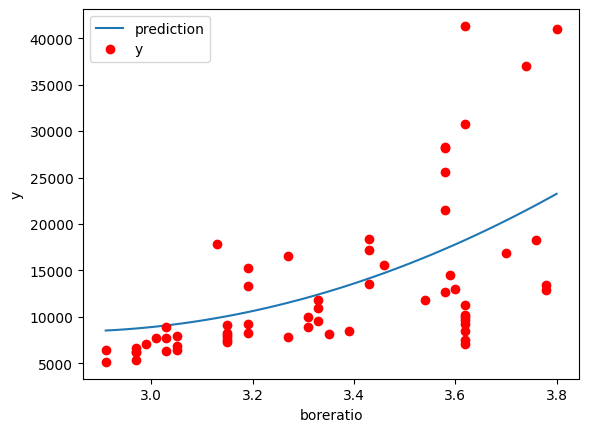

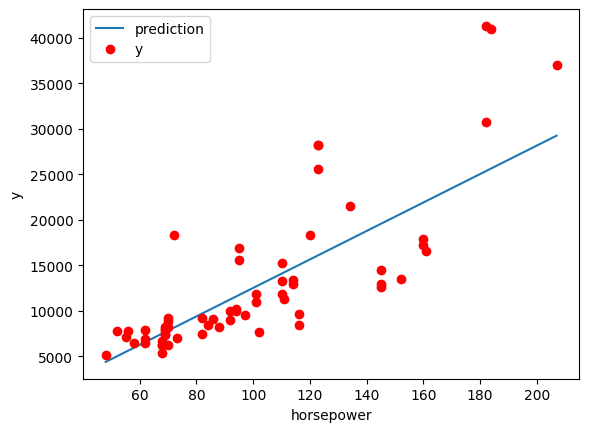

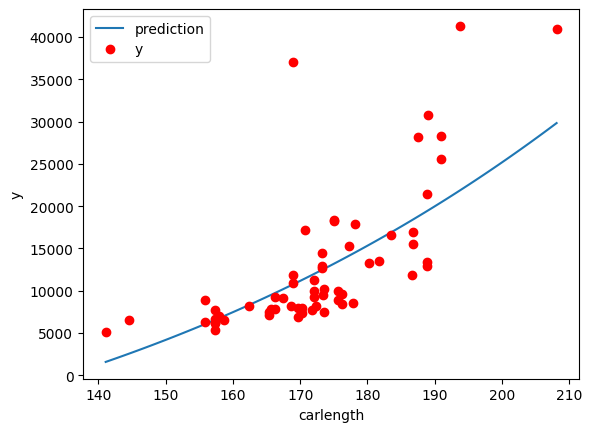

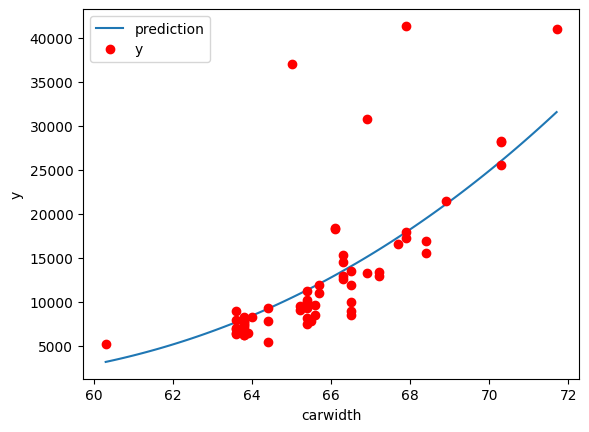

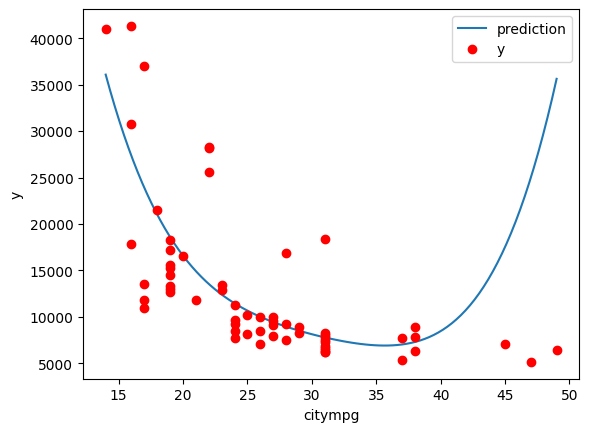

In [38]:
# Enter your code and run the cell
for column in columns:
    search.fit(X_train[[column]], y_train)
    x=np.linspace(X_test[[column]].min(), X_test[[column]].max(),num=100)
    plt.plot(x,search.predict(x.reshape(-1,1)),label="prediction")
    plt.plot(X_test[column],y_test,'ro',label="y")
    plt.xlabel(column)
    plt.ylabel("y")
    plt.legend()
    plt.show()

<details>
    <summary>Click here for Solution</summary>

```python
 
for column in columns:
    search.fit(X_train[[column]], y_train)
    x=np.linspace(X_test[[column]].min(), X_test[[column]].max(),num=100)
    plt.plot(x,search.predict(x.reshape(-1,1)),label="prediction")
    plt.plot(X_test[column],y_test,'ro',label="y")
    plt.xlabel(column)
    plt.ylabel("y")
    plt.legend()
    plt.show()
```

</details>


## Lasso Regression


In this section, let's review the Lasso (Least Absolute Shrinkage and Selection Operator) Regression. Lasso Regression makes the prior assumption that our coefficients have Laplace (double-exponential) distribution around zero. The scale parameter of the distribution is inversely proportional to the parameter alpha. The main advantage of LASSO Regression is that many coefficients are set to zero, therefore they are not required. This has many advantages, one of them is that you may not need to collect and/or store all of the features. This may save resources. For example, if the feature was some medical test, you would no longer need to perform that test. Let's see how the parameter alpha changes the model.  We minimize the MSE, but we also penalize large weights by including their sum of absolute values $||\textbf{w}||_1$ , symbolically:


$\hat{\textbf{w}}= \underset{\textbf{w}}{\mathrm{argmin}} {
||\textbf{y}  - \textbf{Xw} ||^2_2+ \alpha  ||\textbf{w}||_1 }$

This regularization or penalty term makes many coefficients zero, making the model easy to understand and can also be used for feature selection. There are some drawbacks to this technique. It takes longer time to train and the solution may not be unique. Alpha controls the trade-off between MSE and penalization or regularization term and is chosen via cross-validation.  Let's see how the parameter alpha changes the model. Note, as before, our test data will be used as validation data. Let's create a Ridge Regression object, setting the regularization parameter (alpha) to 0.01.


In [39]:
la = Lasso(alpha=0.1)
la.fit(X_train,y_train)
la

Lasso(alpha=0.1)

Let's make a prediction.


In [40]:
predicted = la.predict(X_test)
predicted

array([27650.77820799, 21440.56084624, 10769.0749412 , 12143.5195319 ,
       26103.2305392 ,  5426.83567166,  8100.36520596,  7548.82281176,
       10101.59356599,  9468.72596194, 17337.59695589,  7257.17207381,
       16450.26941837, 10814.03012439, 39694.82170091,  5537.76494294,
         303.01910275, 15708.099564  , 10788.51069981, 11449.5496481 ,
       10848.34025431, 15795.6794752 , 10533.29563055,  3628.25688421,
        7007.80770953, 28649.26889779, 18381.14598578, 15177.62314952,
        4453.77914054, 16391.96444006, 26769.84807467,  5816.37413296,
        4893.00360033, 16647.01478476,  8385.37550631, 30413.45676957,
       12373.18494804, 12974.07144541,  6297.72891626, 16141.01340268,
        8142.85535923, 15094.05712682, 14725.99013699,  5249.8873624 ,
        6254.63789045,  9119.33603424,  5816.37413296,  7230.55655438,
       16691.48322558, 15565.727763  ,  5043.28287228, 21855.778358  ,
        7102.5021522 , 11438.65189317,  4390.76667314, 16513.58266633,
      

Let's calculate the $R^2$ on the training and testing data and see how it performs compared to the other methods.


In [41]:
print("R^2 on training  data ",lm.score(X_train, y_train))
print("R^2 on testing data ",lm.score(X_test,y_test))

R^2 on training  data  0.9262722224294516
R^2 on testing data  0.8471124710252232


If we compare the Lasso Regression to the  Ridge Regression model we see that the results on the $R^2$ are slightly worse, but most of the coefficients are zero.


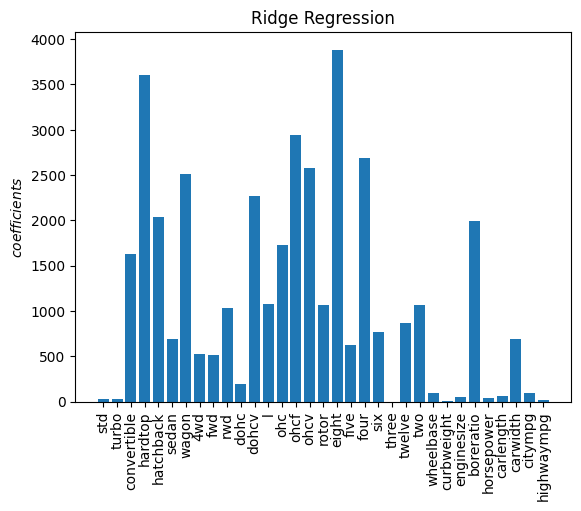

R^2 on training  data  0.9190312321691605
R^2 on testing data  0.807983068907448


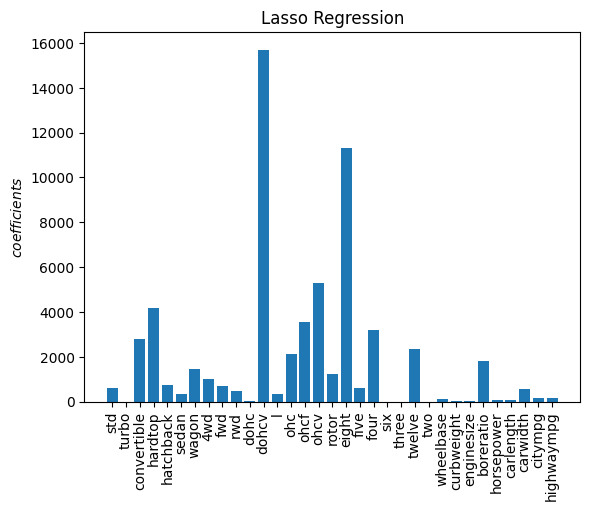

R^2 on training  data  0.9262718588959917
R^2 on testing data  0.8432243138721142


In [42]:
plot_coef(X,rr,name="Ridge Regression")
plot_coef(X,la,name="Lasso Regression")

Similar to the Ridge Regression, if we increase the value of alpha, the coefficients will get smaller. Additionally, many coefficients become zero. Moreover, the model performance relationship becomes more complex. As a result, we use the validation data to select a value for alpha. Here, we plot the coefficients and $R^2$ of the test data on the vertical axes and alpha values on the horizontal axis.


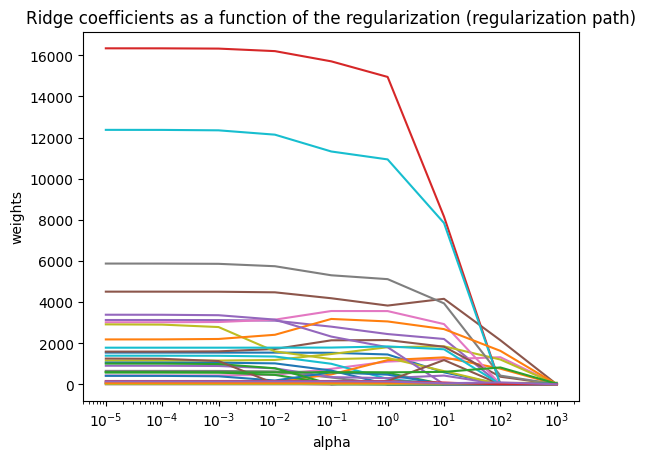

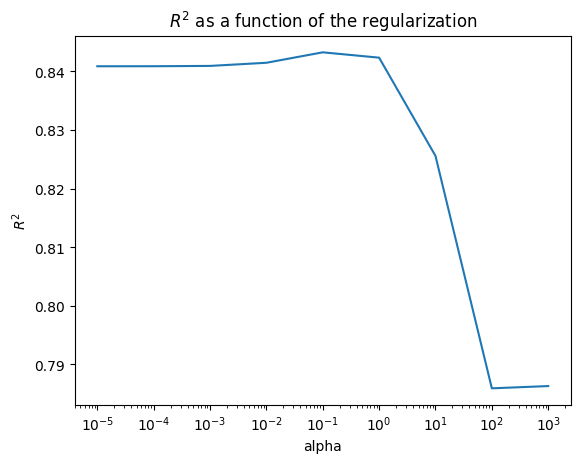

In [43]:
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
R_2=[]
coefs = []
for alpha in alphas:
    la=Lasso(alpha=alpha)
    
    la.fit(X_train, y_train)
    coefs.append(abs(la.coef_))
    R_2.append(la.score(X_test,y_test))


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization (regularization path)")
plt.show()


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()

## Pipeline


We can also create a Pipeline object and apply a set of transforms sequentially. Then, we can apply polynomial features, perform data standardization, then apply Lasso Regression.  We also use `StandardScaler` as a step in our pipeline. Scaling your data is necessary step in LASSO Regression, as it will penalize features with a large magnitudes.

We start by creating a pipeline object.


In [44]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.2))]
pipe = Pipeline(Input)

Then we fit the object, and make our predictions.


In [45]:
pipe.fit(X_train, y_train)
pipe.predict(X_test)

array([27638.40615726, 25193.4225569 ,  9540.51989197, 11846.3552167 ,
       29910.27976213,  6763.7468756 ,  7641.24341483,  7685.09086631,
        8159.0888212 , 10070.5614497 , 16146.30157165,  8495.45878452,
       17221.46659223, 11173.90847907, 37793.90880269,  7075.60152085,
        4685.58897576, 12840.89650783,  9503.54540902,  7848.83795211,
       10205.7000406 , 14560.80011868,  4269.41981622,  3029.92473899,
        6657.24723604, 28244.1861882 , 10960.07731608, 16035.31718184,
        6217.03685991, 16702.51523609, 29737.3487888 ,  6631.42716864,
        7302.38894587, 23394.51085554,  8996.52485981, 35648.35063023,
       11673.02535401, 14307.76521226,  6037.19612759, 13013.53298152,
        7313.72750317, 16870.85976321, 15109.35946846,  6793.62756442,
        6633.70044783,  8925.34478795,  6631.42716864,  5689.70352573,
       16113.38552048, 12809.64838902,  5981.43728204, 17262.4751753 ,
        7739.10734231, 10868.67734225,  6191.38095749, 15690.29720238,
      

We can calculate the $R^2$ on the training and testing data sets.


In [46]:
print("R^2 on training  data ",pipe.score(X_train, y_train))
print("R^2 on testing data ",pipe.score(X_test,y_test))

R^2 on training  data  0.9490719402078074
R^2 on testing data  0.853977497236178


As we see, some individual features perform similarly to using all the features (we removed the feature `three` ). Additionally, we see the smaller coefficients seem to correspond to a larger $R^{2}$, therefore  larger coefficients correspond to overfiting.


## GridSearchCV

To search for the best combination of hyperparameters, we can create a  `GridSearchCV()` function as a dictionary of parameter values. The parameters of pipelines can be set by using the name of the key, separated by "\__", then the parameter. Here, we look for different polynomial degrees and different values of alpha.


In [47]:
param_grid = {
    "polynomial__degree": [ 1, 2,3,4,5],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10]
}

To search for the best combination of hyperparameters, we create a  `GridSearchCV` object with a dictionary of parameter values.


In [48]:
search = GridSearchCV(pipe, param_grid, n_jobs=1)
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', Lasso(alpha=1, tol=0.2))]),
             n_jobs=1,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'polynomial__degree': [1, 2, 3, 4, 5]})

Now, we can find the best model.


In [49]:
best=search.best_estimator_
best

Pipeline(steps=[('polynomial',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('ss', StandardScaler()), ('model', Lasso(alpha=10, tol=0.2))])

We can calculate the $R^2$ on the test data.


In [50]:
best.score(X_test,y_test)

0.8682632196298112

## Elastic Net

In this section, let's review the Elastic Net Regression. It combines L1 and L2 priors as regularizes or penalties. So, we can combine the two as follows:


$\hat{\textbf{w}}= \underset{\textbf{w}}{\mathrm{argmin}} {
||\textbf{y}  - \textbf{Xw} ||^2_2+ \alpha  \rho||\textbf{w}||\_1
0.5 \alpha (1 - \rho)  ||\textbf{w}||^2_2 } $


Additionally to the alpha term ($\alpha$), we have a mixing parameter, $\rho$, such that 0 $\le$ $\rho$ $\le$ 1. For $\rho$=0, the penalty is an L2 regularization . For $\rho=0$, it is L1 regularization; otherwise, it is a combination of L1 and L2. In *scikit-learn* the parameter is called  `l1_ratio`. Unlike the Ridge Regression, Elastic Net finds zero coefficients. In many cases Elastic Net performs better than Lasso, as it includes features that are correlated with one another. One drawback of the Elastic Net is you have two hyperparameters.  Lets create a model where `alpha=0.1`and `l1_ratio=0.5` and fit the data with this model.


In [51]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
enet.fit(X_train,y_train)

ElasticNet(alpha=0.1)

Let's make a prediction.


In [52]:

predicted=enet.predict(X_test)
predicted

array([26714.4824089 , 19598.86415276, 11024.3029392 , 11679.04507242,
       25740.32929708,  5425.27067897,  6492.10075795,  7979.31096963,
        9441.2650813 ,  7728.1460593 , 17205.72565446,  7549.36642758,
       17093.94716773, 11067.08318609, 38030.67040642,  5173.87911905,
       -2331.87701878, 16423.45486169, 11415.21305535, 10577.74696404,
       11848.19038931, 19872.63755179,  8835.15390216,  3142.56776653,
        6802.04471906, 27470.28396862, 17637.18797759, 15852.62423984,
        5198.71568241, 16985.26243271, 26664.52966942,  5348.56519643,
        6061.83530148, 21725.20978558,  8177.27745998, 28446.31214472,
       12166.00173012, 11507.24747393,  5939.50279689, 16588.99788837,
        8436.42603568, 14494.96360956, 15355.26743358,  5051.66342515,
        6752.48760013,  8994.96117254,  5348.56519643,  7321.87784004,
       17313.7254499 , 16370.86775869,  4462.04370198, 21268.21419309,
        5963.58343566, 12081.52515186,  5174.73611014, 16553.12452435,
      

Let's calculate the $R^2$ on the test data.


In [53]:
print("R^2 on training  data ", enet.score(X_train, y_train))
print("R^2 on testing data ", enet.score(X_test,y_test))

R^2 on training  data  0.8988174004967847
R^2 on testing data  0.8072608281341807


If we compare the Elastic Net to Lasso Regression and  Ridge Regression, we see the results on the $R^2$ are better than the Elastic Net and many of the coefficients are zero.


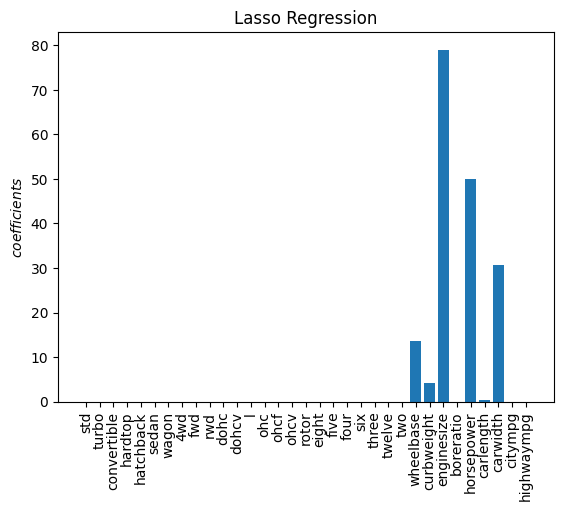

R^2 on training  data  0.8283406619647626
R^2 on testing data  0.7863171813893053


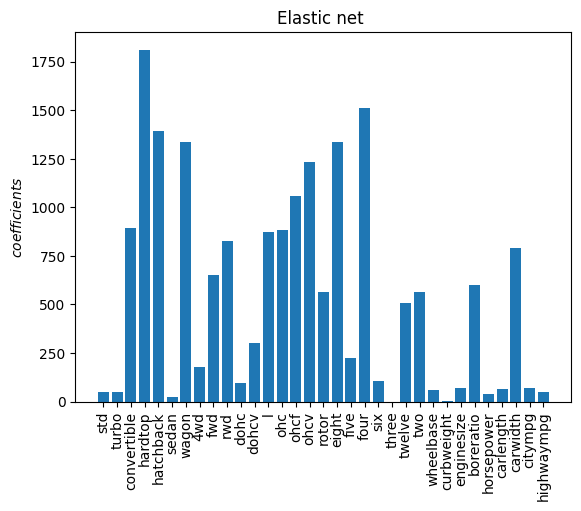

R^2 on training  data  0.8988174004967847
R^2 on testing data  0.8072608281341807


In [54]:
plot_coef(X,la,name="Lasso Regression")
plot_coef(X,enet,name="Elastic net ")

## graph that leads to error 

## Exercise 3

Create and fit the Elastic Net model and the Ridge Regression models and plot the coefficients for both models using the `plot_coef()`function.


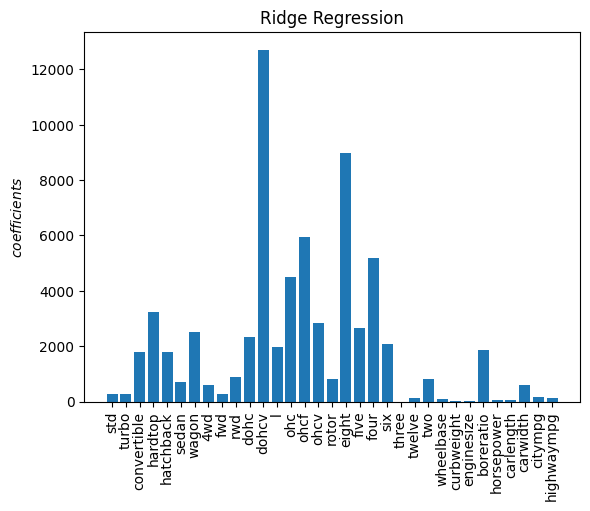

R^2 on training  data  0.9262583145923291
R^2 on testing data  0.8454081419624927


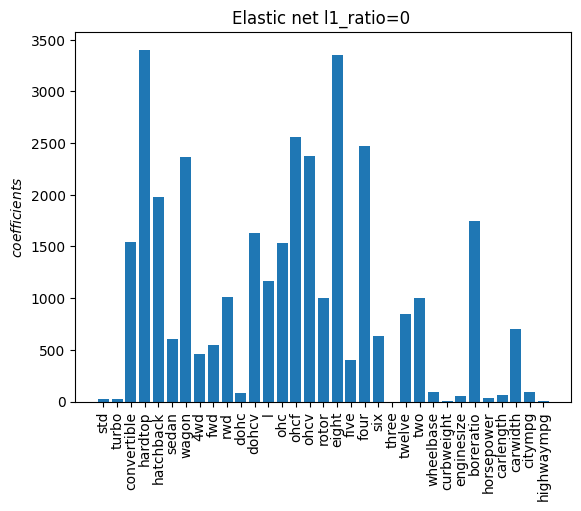

R^2 on training  data  0.9169259598993407
R^2 on testing data  0.8069174475383022


In [55]:
# Enter your code and run the cell
enet = ElasticNet(alpha=0.01, l1_ratio=0)
enet.fit(X_train,y_train)
rr = Ridge(alpha=0.01)
rr.fit(X_train,y_train)
plot_coef(X,rr,name="Ridge Regression")

plot_coef(X,enet,name="Elastic net l1_ratio=0 ")


<details>
    <summary>Click here for Solution</summary>

```python
enet = ElasticNet(alpha=0.01, l1_ratio=0)
enet.fit(X_train,y_train)
rr = Ridge(alpha=0.01)
rr.fit(X_train,y_train)
plot_coef(X,rr,name="Ridge Regression")

plot_coef(X,enet,name="Elastic net l1_ratio=0 ")
```

</details> 


## Exercise 4

Create a Pipeline object, apply polynomial features (degree = 2), perform data standardization, then apply Elastic Net with `alpha=0.1` and  `l1_ratio=0.1` parameters. Fit the model using the training data, then calculate the $R^2$ on the training and testing data.


In [56]:
# Enter your code and run the cell
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',ElasticNet(alpha=0.1, l1_ratio=0.1))]
pipe = Pipeline(Input)
pipe.fit(X_train, y_train)
print("R^2 on training  data ",pipe.score(X_train, y_train))
print("R^2 on testing data ",pipe.score(X_test,y_test))

R^2 on training  data  0.9747505819790091
R^2 on testing data  0.9108826638584328


<details>
    <summary>Click here for Solution</summary>

```python
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',ElasticNet(alpha=0.1, l1_ratio=0.1))]
pipe = Pipeline(Input)
pipe.fit(X_train, y_train)
print("R^2 on training  data ",pipe.score(X_train, y_train))
print("R^2 on testing data ",pipe.score(X_test,y_test))
```

</details>


## Exercise 5


Search for the best combination of  hyperparameters by creating  a  `GridSearchCV` object for Elastic Net Regression. Find the best parameter values using the pipeline object, as used in the above examples. Use`param_grid`, then find thee $R^2$ on the test data using the best estimator.


In [57]:
param_grid = {
    "polynomial__degree": [ 1, 2,3,4,5],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10],
    "model__l1_ratio":[0.1,0.25,0.5,0.75,0.9]
}


In [58]:
# Enter your code and run the cell
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',ElasticNet(tol = 0.2))]
pipe = Pipeline(Input)
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_test, y_test)
best=search.best_estimator_
best.score(X_test,y_test)

0.9085052680271295

<details>
    <summary>Click here for Solution</summary>

```python
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',ElasticNet(tol = 0.2))]
pipe = Pipeline(Input)
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_test, y_test)
best=search.best_estimator_
best.score(X_test,y_test)
```

</details>


## Principal Component Analysis (Optional)


In this example, we will explore Principal Component Analysis to reduce the dimensionality of our data.
We will do so by creating a Pipeline object first, then applying standard scaling and performing PCA, and then applying Elastic Net Regularization with the following parametrs: `tol=0.2`, `alpha=0.1` and  `l1_ratio=0.1`.
Finally, we will fit the model using the training data, then calculate the  $𝑅^2$  on the training and testing data sets.


Before adding PCA as a prep-processing step, we have to standardize our data. Scaling the features makes them have the same standard deviation.


In [59]:
scaler = StandardScaler()
X_train[:] = scaler.fit_transform(X_train)
X_train.columns = [f'{c} (scaled)' for c in X_train.columns]

Now, let's perform PCA.


In [60]:
pca = PCA()
pca.fit(X_train)

PCA()


We can find the projection of the dataset onto the principal components, let's call it X_train_hat , this is our "new" dataset, it is the same shape as the original dataset.


In [61]:
X_train_hat = pca.transform(X_train)
print(X_train_hat.shape)

(143, 35)


Let's look at the new dataset as a dataframe.


In [62]:
X_train_hat_PCA = pd.DataFrame(columns=[f'Projection  on Component {i+1}' for i in range(len(X_train.columns))], data=X_train_hat)
X_train_hat_PCA.head()

,Projection on Component 1,Projection on Component 2,Projection on Component 3,Projection on Component 4,Projection on Component 5,Projection on Component 6,Projection on Component 7,Projection on Component 8,Projection on Component 9,Projection on Component 10,...,Projection on Component 26,Projection on Component 27,Projection on Component 28,Projection on Component 29,Projection on Component 30,Projection on Component 31,Projection on Component 32,Projection on Component 33,Projection on Component 34,Projection on Component 35
0,-1.275886,-0.387124,-0.188967,-0.264790,0.478277,1.029336,-0.524741,0.088927,0.615081,0.352062,...,0.017035,0.059484,2.074919e-16,-9.312048e-17,3.412476e-17,-2.349156e-16,-1.421985e-16,8.849580e-18,1.984391e-16,-2.476205e-16
1,2.500963,0.720383,1.465152,0.090420,2.089170,1.631427,-0.821222,-2.142983,-1.101182,1.000920,...,0.038730,0.035999,7.361936e-16,-7.578952e-16,-2.071714e-16,2.339575e-16,4.984500e-16,3.395539e-17,-1.061211e-15,-1.819726e-16
2,-0.865985,5.018715,0.135809,-1.107474,1.541035,-1.167279,1.686782,-0.180176,-0.079122,-0.543977,...,0.004004,-0.014941,1.107887e-16,-1.106759e-15,-1.669406e-16,-2.037136e-15,4.813461e-16,1.480566e-16,-1.038381e-16,2.819254e-16
3,-4.363854,-1.442349,0.211128,-0.305657,1.246931,-0.077329,0.228809,-0.300396,0.832960,-0.080305,...,-0.000446,-0.107617,-5.707102e-16,1.291894e-16,1.139378e-16,-3.490387e-16,-4.287000e-16,2.213292e-16,-2.836747e-16,-4.317963e-16
4,1.837786,-0.998711,-1.073234,-0.687229,-1.477782,-1.474179,0.463054,-0.821021,-0.318107,-0.070852,...,-0.143789,-0.129719,-4.129676e-16,7.441764e-16,-9.793191e-16,4.397545e-16,-3.073440e-16,-9.072696e-17,-5.918377e-16,-1.866892e-16


Now, let's see how much variance can be explained using these principal components (PCs).


Text(0.5, 1.0, 'Component-wise variance and cumulative explained variance')

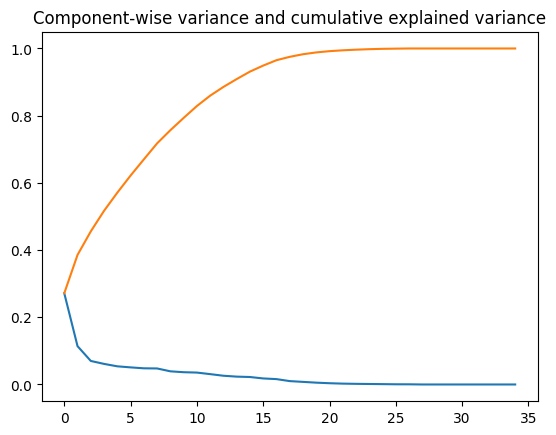

In [63]:
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise variance and cumulative explained variance")

In the graph above, the component-wise variance is depicted by the blue line, and the cumulative explained variance is explained by the orange line. We are able to explain \~100% of the variance using just the first 20 PCs. Let's filter our dataset down to these 20 PCs.


In [64]:
N = 20
X_train_hat_PCA = X_train_hat_PCA.iloc[:, :N]

Let's create an Elastic Net model where `tol=0.2`,  `alpha=0.1` and  `l1_ratio=0.1` and fit the data with this model.


In [65]:
enet = ElasticNet(tol = 0.2, alpha=100, l1_ratio=0.75)
enet.fit(X_train_hat_PCA, y_train)

ElasticNet(alpha=100, l1_ratio=0.75, tol=0.2)

## Exercise 6 (Optional)

In this Exercise, create a Pipeline object, apply standard scaling, perform PCA and then finally fit an Elastic Net with `tol=0.2`, `alpha=0.1` and  `l1_ratio=0.1` parameters. Calculate the scores, $R^2$, on the training and testing data sets.


In [ ]:
# Enter your code and run the cell
Input=[ ('scaler', StandardScaler()), ('pca', PCA(n_components = N)), ('model', ElasticNet(tol =0.2, alpha=0.1, l1_ratio=0.1))]
pipe = Pipeline(Input)
pipe.fit(X_train, y_train)
print("R^2 on training  data ", pipe.score(X_train, y_train))
print("R^2 on testing data ", pipe.score(X_test,y_test))

<details>
    <summary>Click here for Solution</summary>

```python

Input=[ ('scaler', StandardScaler()), ('pca', PCA(n_components = N)), ('model', ElasticNet(tol =0.2, alpha=0.1, l1_ratio=0.1))]
pipe = Pipeline(Input)
pipe.fit(X_train, y_train)
print("R^2 on training  data ", pipe.score(X_train, y_train))
print("R^2 on testing data ", pipe.score(X_test,y_test))
```

</details>


# Congratulations! - You have completed the lab


## Author


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Joseph Santarcangelo</a>


### Other Contributors

[Svitlana Kramar](https://www.linkedin.com/in/svitlana-kramar?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01)

[Kopal Garg](https://www.linkedin.com/in/gargkopal/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01)


<!--## Change Log
-->


<!--| Date (YYYY-MM-DD) | Version | Changed By  | Change Description                               |
| ----------------- | ------- | ----------- | ------------------------------------------------ |
| 2022-05-02        | 0.1     | Svitlana K. | Reviewed and fixed minor code and grammar errors |
| 2022-05-10        | 0.2     | Kopal G.    | Added the PCA example                            |-->
